In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [533]:
def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    pearson_th: float = 0.8,
    spearman_th: float = 0.7,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[pearson_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[0, ii].imshow(output['comm_mat'], cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        im = axes[1, ii].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            axes[0, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            axes[1, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes

### Load data

In [53]:
config = Config()

num_regions = 1024

load = load_organized_data(
    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
    config=config,
    subject=6,
    session=1,
    run=1,
)

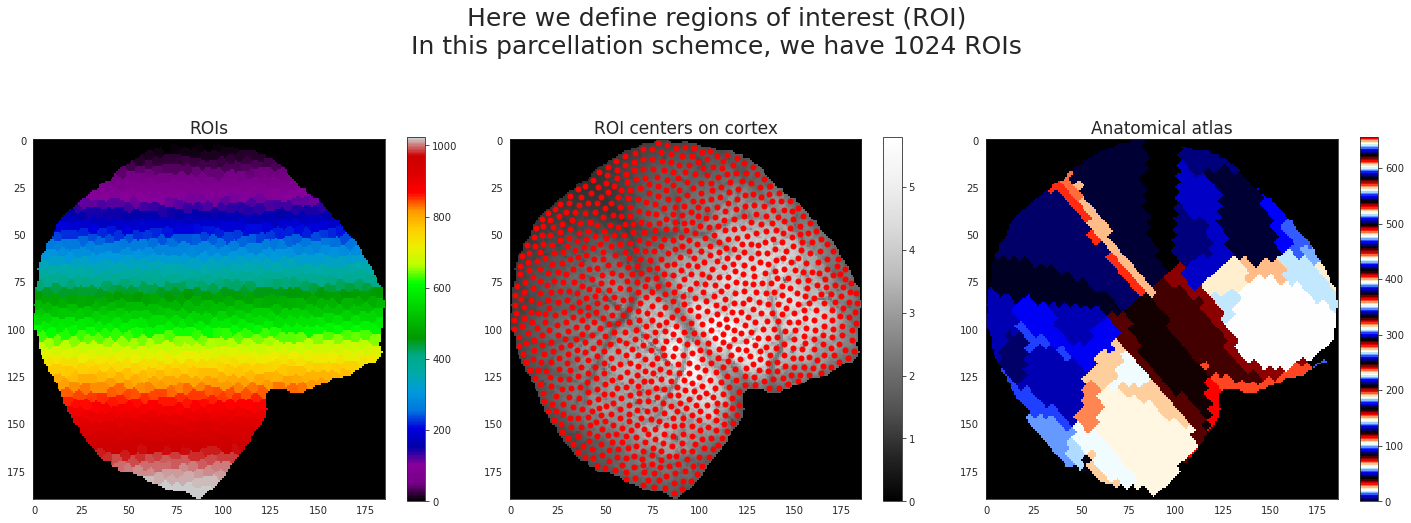

In [54]:
sns.set_style('white')
plt.figure(figsize=(20, 7.5))
plt.subplot(131)
plt.imshow(load['atlas_kmeans'], cmap='nipy_spectral', interpolation='none')
plt.colorbar(shrink=0.8)
plt.title('ROIs', fontsize=17)

plt.subplot(132)
plt.imshow(load['ref'], cmap='Greys_r', interpolation='none')
for j, i in load['kmeans_centers']: 
    plt.plot(i, j, marker='o', color='r', markersize=5)
plt.colorbar(shrink=0.8)
plt.title('ROI centers on cortex', fontsize=17)
    
plt.subplot(133)
plt.imshow(load['atlas'], cmap='flag_r', interpolation='none')
plt.colorbar(shrink=0.8)
plt.title('Anatomical atlas', fontsize=17)

sup = plt.suptitle('Here we define regions of interest (ROI)\nIn this parcellation schemce, we have {:d} ROIs'.format(num_regions), fontsize=25, y=1.02)
plt.tight_layout()

plt.savefig('kmeans_atlas_{:d}.pdf'.format(num_regions), dpi=300, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

### ROI num pix plot

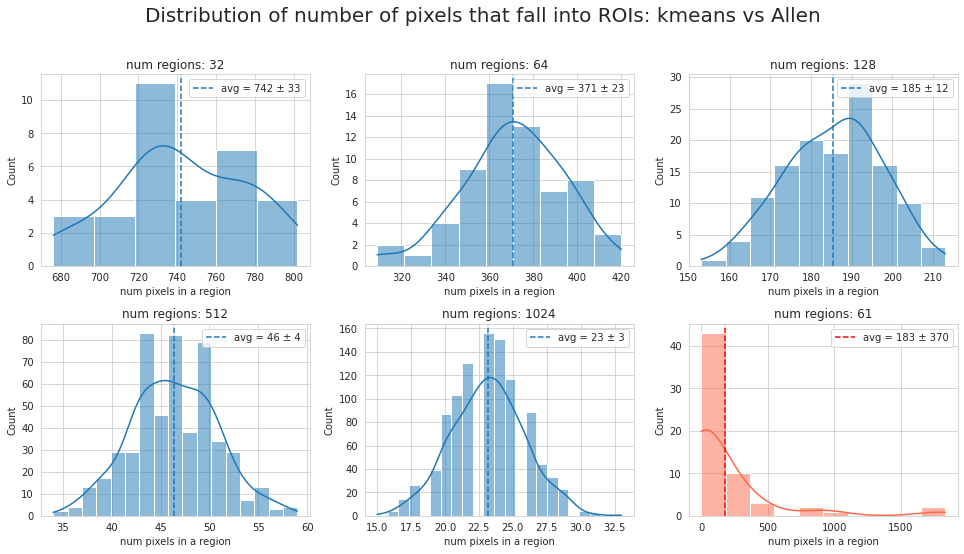

In [158]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(13.5, 7.5), nrows=2, ncols=3)

for idx, num_regions in enumerate([32, 64, 128, 512, 1024]):
    i, j = idx//3, idx%3
    
    load = load_organized_data(
        folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
        config=config,
        subject=6,
        session=1,
        run=1,
    )

    num_pixs_per_roi = {k: len(np.where(load['atlas_kmeans'] == k)[0]) for k in range(1, num_regions+1)}
    _ = sns.histplot(num_pixs_per_roi.values(), kde=True, ax=axes[i, j])
    mean = np.mean(list(num_pixs_per_roi.values()))
    sd = np.std(list(num_pixs_per_roi.values()))
    axes[i, j].axvline(mean, ls='--', label='avg = {:.0f} ± {:.0f}'.format(mean, sd))
    axes[i, j].legend(loc='upper right')
    axes[i, j].set_title('num regions: {:d}'.format(num_regions))
    axes[i, j].set_xlabel('num pixels in a region')

load = load_organized_data(
    folder='atlas-allen_unfiltered_unnormalized',
    config=config,
    subject=6,
    session=1,
    run=1,
)
num_regions = len(np.unique(load['atlas'])) - 1
num_pixs_per_roi = {k: len(np.where(load['atlas'] == k)[0]) for k in range(1, num_regions+1)}
mean = np.mean(list(num_pixs_per_roi.values()))
sd = np.std(list(num_pixs_per_roi.values()))
_ = sns.histplot(num_pixs_per_roi.values(), kde=True, palette='Reds', bins=10, ax=axes[-1, -1])
axes[-1, -1].axvline(mean, ls='--', color='r', label='avg = {:.0f} ± {:.0f}'.format(mean, sd))
axes[-1, -1].legend(loc='upper right')
axes[-1, -1].set_title('num regions: {:d}'.format(num_regions))
axes[-1, -1].set_xlabel('num pixels in a region')


sup = plt.suptitle('Distribution of number of pixels that fall into ROIs: kmeans vs Allen', fontsize=20, y=1.02)
fig.tight_layout()
fig.savefig('dist_pix_roi.pdf'.format(num_regions), dpi=500, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

### Means and SD plot

In [199]:
config = Config()

dict_list = []
for num_regions in tqdm([32, 128, 256, 1024]):
    for subject in tqdm(range(1, config.num_subjects+1), leave=False):
        for session in tqdm(range(1, config.num_sessions+1), leave=False):
            for run in range(1, config.num_runs+1):

                load = load_organized_data(
                    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
                    config=config,
                    subject=subject,
                    session=session,
                    run=run,
                )
                if load is None:
                    continue
                    
                means = [item.mean() for item in load['ca'].values()]
                stds = [item.std() for item in load['ca'].values()]

                data_dict = {
                    'region_idx': list(load['ca']),
                    'num_regions': [num_regions] * num_regions,
                    'subject': [subject] * num_regions,
                    'session': [session] * num_regions,
                    'run': [run] * num_regions,
                    'mu_run': [np.mean(means)] * num_regions,
                    'sigma_run': [np.mean(stds)] * num_regions,
                    'mu_roi': means,
                    'sigma_roi': stds,
                }
                dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df = reset_df(df)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

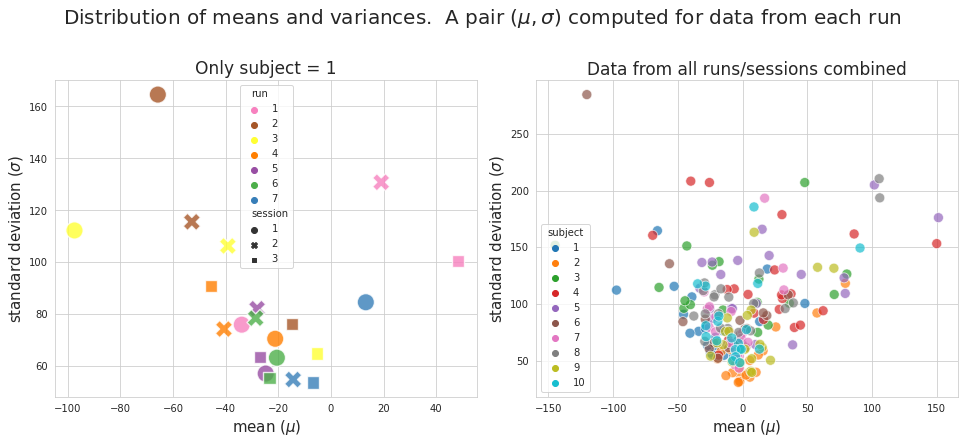

<Figure size 576x432 with 0 Axes>

<Figure size 936x864 with 0 Axes>

In [253]:
sns.set_style('whitegrid')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13.5, 6))

selected_df = df.loc[(df.num_regions == 256) & (df.region_idx == 1) & (df.subject == 1)]
palette_ = sns.color_palette('Set1_r', n_colors=config.num_runs)
palette = {i+1: list(palette_)[i] for i in range(config.num_runs)}

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=selected_df,
    x='mu_run',
    y='sigma_run',
    style='session',
    hue='run',
    palette=palette,
    s=300,
    alpha=0.8,
    ax=ax0,
)
ax0.set_title('Only subject = 1', fontsize=17)


selected_df = df.loc[(df.num_regions == 256) & (df.region_idx == 1) & (df.mu_run < 1000)]
palette = {i+1: 'C{:d}'.format(i) for i in range(config.num_subjects)}

sns.set_style('whitegrid')
plt.figure(figsize=(13, 12))
sns.scatterplot(
    data=selected_df,
    x='mu_run',
    y='sigma_run',
    hue='subject',
    palette=palette,
    s=100,
    alpha=0.7,
    ax=ax1,
)
ax1.set_title('Data from all runs/sessions combined', fontsize=17)

for ax in [ax0, ax1]:
    ax.set_xlabel('mean ($\mu$)', fontsize=15)
    ax.set_ylabel('standard deviation ($\sigma$)', fontsize=15)

msg = 'Distribution of means and variances.  A pair ($\mu, \sigma$) computed for data from each run'
sup = fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
fig.savefig('dist_mu_sigma.pdf'.format(num_regions), dpi=500, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

In [305]:
palette_run = sns.color_palette('Set1_r', n_colors=config.num_runs)

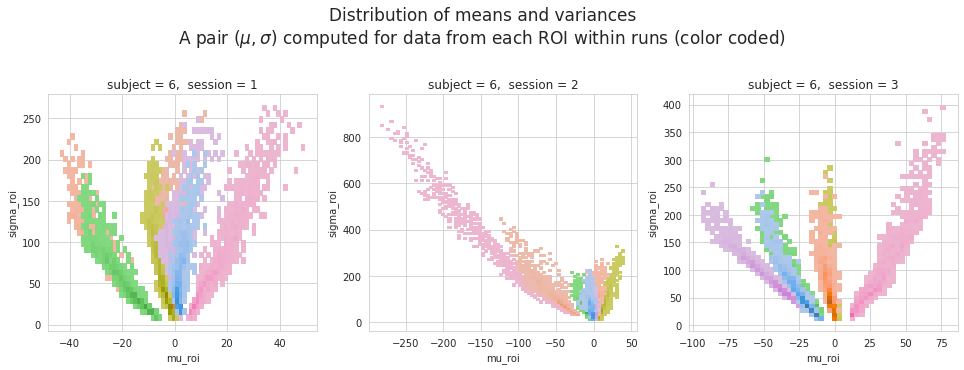

In [306]:
subject = 6

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(13.5, 5))

for session in range(1, config.num_sessions+1):
    selected_df = df.loc[
        (df.num_regions == 1024) &
        (df.subject == subject) &
        (df.session == session) &
        (df.mu_run < 1000)
    ]
    palette = {i+1: list(palette_run)[i] for i in range(config.num_runs)}
    sns.histplot(
        data=selected_df,
        x='mu_roi',
        y='sigma_roi',
        hue='run',
        palette=palette,
        ax=axes[session-1],
    )
    axes[session-1].set_title("subject = {:d},  session = {:d}".format(subject, session))
    axes[session-1].get_legend().remove()
    
msg = 'Distribution of means and variances\n'
msg += 'A pair ($\mu, \sigma$) computed for data from each ROI within runs (color coded)'
sup = fig.suptitle(msg, fontsize=17, y=1.02)
fig.tight_layout()
fig.savefig('dist_mu_sigma_roi_runs.png'.format(num_regions), dpi=300, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

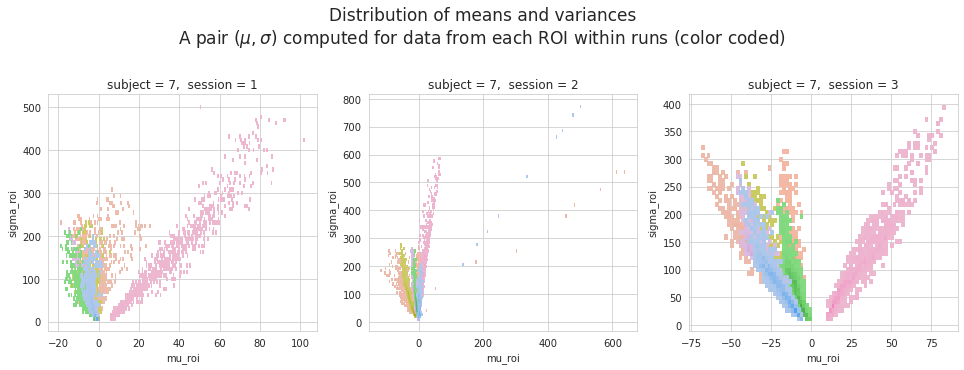

In [319]:
subject = 7

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(13.5, 5))

for session in range(1, config.num_sessions+1):
    selected_df = df.loc[
        (df.num_regions == 1024) &
        (df.subject == subject) &
        (df.session == session) &
        (df.mu_run < 1000)
    ]
    palette = {i+1: list(palette_run)[i] for i in range(config.num_runs)}
    sns.histplot(
        data=selected_df,
        x='mu_roi',
        y='sigma_roi',
        hue='run',
        palette=palette,
        ax=axes[session-1],
    )
    axes[session-1].set_title("subject = {:d},  session = {:d}".format(subject, session))
    axes[session-1].get_legend().remove()
    
msg = 'Distribution of means and variances\n'
msg += 'A pair ($\mu, \sigma$) computed for data from each ROI within runs (color coded)'
sup = fig.suptitle(msg, fontsize=17, y=1.02)
fig.tight_layout()
# fig.savefig('dist_mu_sigma_roi_runs.png'.format(num_regions), dpi=300, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

In [298]:
palette_session = {i+1: 'C{:d}'.format(i) for i in range(config.num_sessions)}

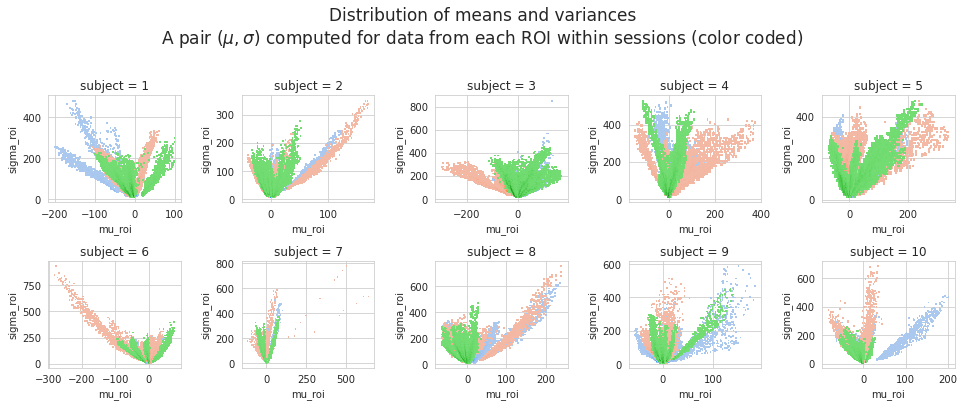

In [304]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 5, figsize=(13.5, 5.5))

for subject in range(1, config.num_subjects+1):
    i, j = (subject - 1) // 5, (subject - 1) % 5
    
    selected_df = df.loc[
        (df.num_regions == 1024) &
        (df.subject == subject) &
        (df.mu_run < 1000)
    ]
    sns.histplot(
        data=selected_df,
        x='mu_roi',
        y='sigma_roi',
        hue='session',
        palette=palette_session,
        ax=axes[i, j],
    )
    axes[i, j].set_title("subject = {:d}".format(subject))
    axes[i, j].get_legend().remove()

msg = 'Distribution of means and variances\n'
msg += 'A pair ($\mu, \sigma$) computed for data from each ROI within sessions (color coded)'
sup = fig.suptitle(msg, fontsize=17, y=1.02)
fig.tight_layout()
fig.savefig('dist_mu_sigma_roi_sessions.png'.format(num_regions),
            dpi=300, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

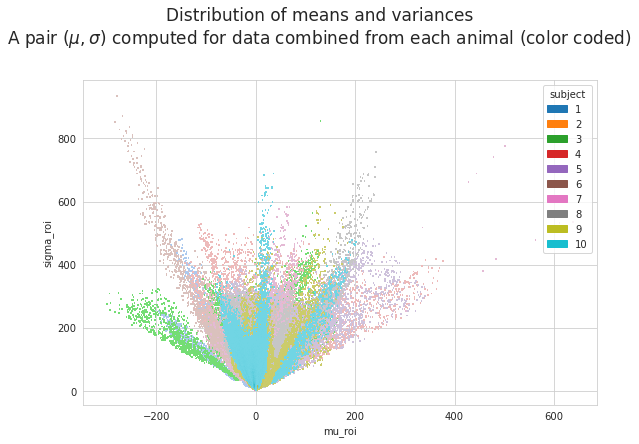

In [303]:
plt.figure(figsize=(8, 6))

selected_df = df.loc[(df.num_regions == 1024) & (df.mu_run < 1000)]
palette = {i+1: 'C{:d}'.format(i) for i in range(config.num_subjects)}
sns.histplot(data=selected_df, x='mu_roi', y='sigma_roi', hue='subject', palette=palette)

msg = 'Distribution of means and variances\n'
msg += 'A pair ($\mu, \sigma$) computed for data combined from each animal (color coded)'
sup = plt.suptitle(msg, fontsize=17, y=1.02)
plt.tight_layout()
plt.savefig('dist_mu_sigma_roi_subjects.png'.format(num_regions),
            dpi=300, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

In [390]:
selected_df = df.loc[(df.num_regions == 1024) & (df.mu_run < 1000) & (df.mu_roi > 350)]
selected_df

region_idx  num_regions  subject  session  run      mu_run  \
155964          29         1024        4        2    1  149.417506   
155965          30         1024        4        2    1  149.417506   
156004          69         1024        4        2    1  149.417506   
156013          78         1024        4        2    1  149.417506   
156014          79         1024        4        2    1  149.417506   
156027          92         1024        4        2    1  149.417506   
156031          96         1024        4        2    1  149.417506   
156038         103         1024        4        2    1  149.417506   
156039         104         1024        4        2    1  149.417506   
156058         123         1024        4        2    1  149.417506   
220443        1020         1024        7        2    2  -27.824359   
220444        1021         1024        7        2    2  -27.824359   
220445        1022         1024        7        2    2  -27.824359   
220446        1023         1024        7        2    2  -27.824359   
220447        1024         1024        7        2    2  -27.824359   
225563        1020         1024        7        2    7    4.728302   
225565        1022         1024        7        2    7    4.728302   
225566        1023         1024        7        2    7    4.728302   
225567        1024         1024        7        2    7    4.728302   

         sigma_run      mu_roi   sigma_roi  
155964  161.958098  363.987870  323.025932  
155965  161.958098  353.560088  309.342759  
156004  161.958098  365.773317  351.319670  
156013  161.958098  354.966495  341.655996  
156014  161.958098  367.389427  380.793604  
156027  161.958098  354.630076  389.116461  
156031  161.958098  376.608524  410.995176  
156038  161.958098  358.207974  357.924282  
156039  161.958098  369.547930  391.180201  
156058  161.958098  362.675156  420.494384  
220443  100.078345  483.211834  419.693195  
220444  100.078345  457.125743  382.991915  
220445  100.078345  611.350103  533.725587  
220446  100.078345  639.077969  534.469915  
220447  100.078345  562.513997  476.591110  
225563   69.869234  444.854815  689.375268  
225565   69.869234  478.031475  741.112266  
225566   69.869234  428.161205  662.924358  
225567   69.869234  501.286229  777.207433

In [384]:
num_regions = 1024

load = load_organized_data(
    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
    subject=7,
    session=2,
    run=2,
)

In [385]:
x = np.zeros(load['atlas_kmeans'].shape + (list(load['ca'].values())[0].shape[-1],))

for key, data in load['ca'].items():
    
    num_nan = np.isnan(load['ca'][key]).mean().sum()
    if num_nan > 0:
        print(key, num_nan)
        continue
    
    x[load['atlas_kmeans'] == key] = load['ca'][key]

x.shape

(179, 184, 5500)

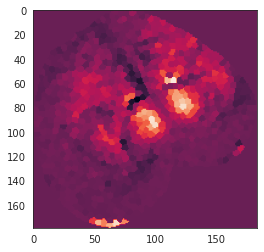

In [386]:
sns.set_style('white')
plt.imshow(x[..., 1400])

In [341]:
num_regions = 1024

load = load_organized_data(
    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
    subject=4,
    session=2,
    run=1,
)

In [342]:
x = np.zeros(load['atlas_kmeans'].shape + (list(load['ca'].values())[0].shape[-1],))

for key, data in load['ca'].items():
    
    num_nan = np.isnan(load['ca'][key]).mean().sum()
    if num_nan > 0:
        print(key, num_nan)
        continue
    
    x[load['atlas_kmeans'] == key] = load['ca'][key]

x.shape

(178, 167, 5500)

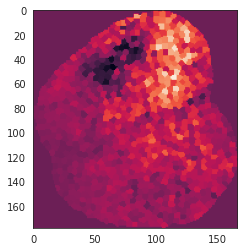

In [378]:
sns.set_style('white')
plt.imshow(x[..., 4500])

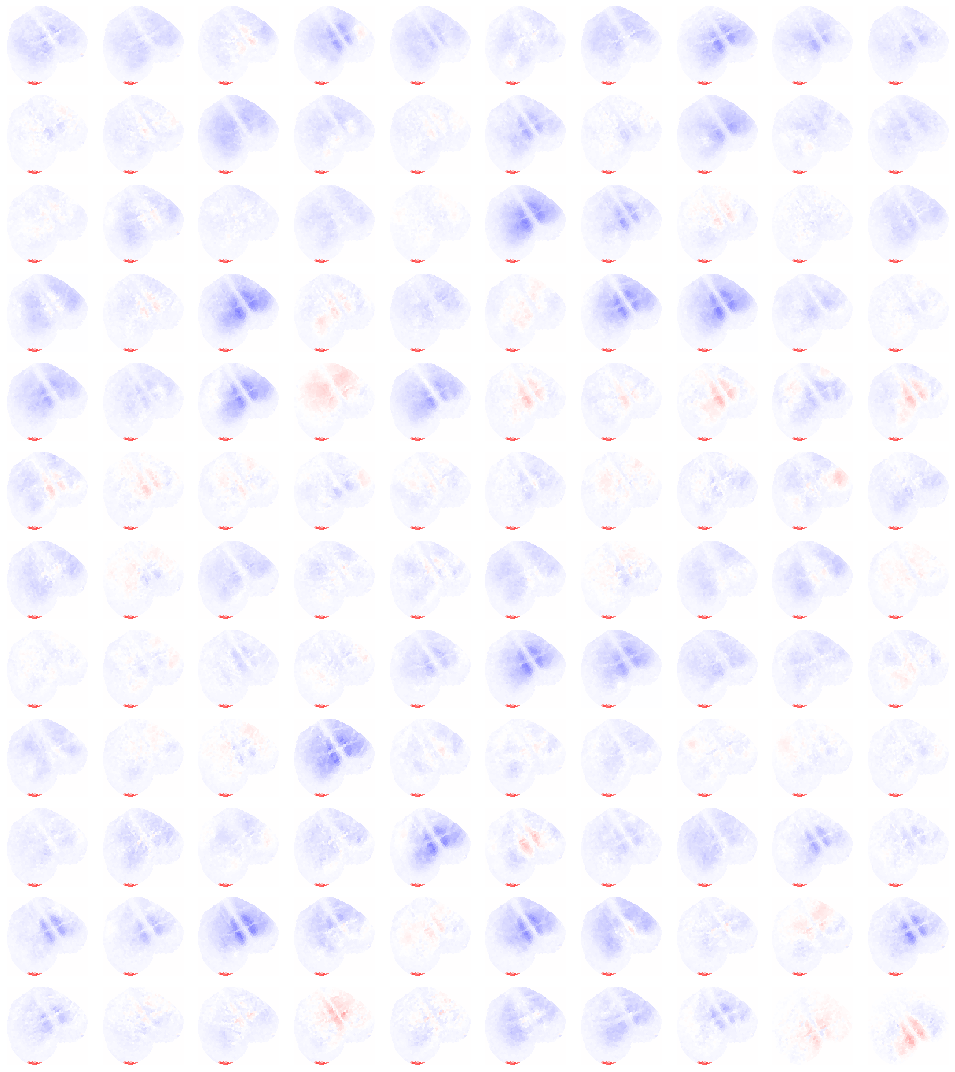

In [387]:
# t = 1800
t = 2500
res = 10

_slice = x[..., t: t + res * 120]
vminmax = np.max(np.abs(_slice))

sns.set_style('white')
nrows, ncols = 12, 10
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 15))

for idx in range(_slice.shape[-1] // res):
    i, j = idx//ncols, idx%ncols
    axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
    axes[i, j].axis('off')
    
fig.tight_layout()
plt.show()

In [391]:
selected_df = df.loc[(df.num_regions == 1024) & (df.mu_run < 1000) & (df.mu_roi < -250)]
selected_df

region_idx  num_regions  subject  session  run      mu_run  \
137723         220         1024        3        2    4 -143.937793   
137781         278         1024        3        2    4 -143.937793   
137819         316         1024        3        2    4 -143.937793   
137835         332         1024        3        2    4 -143.937793   
137866         363         1024        3        2    4 -143.937793   
137875         372         1024        3        2    4 -143.937793   
137901         398         1024        3        2    4 -143.937793   
137902         399         1024        3        2    4 -143.937793   
137918         415         1024        3        2    4 -143.937793   
137927         424         1024        3        2    4 -143.937793   
137933         430         1024        3        2    4 -143.937793   
137943         440         1024        3        2    4 -143.937793   
137959         456         1024        3        2    4 -143.937793   
138030         527         1024        3        2    4 -143.937793   
138061         558         1024        3        2    4 -143.937793   
138069         566         1024        3        2    4 -143.937793   
138078         575         1024        3        2    4 -143.937793   
138091         588         1024        3        2    4 -143.937793   
138092         589         1024        3        2    4 -143.937793   
138101         598         1024        3        2    4 -143.937793   
138111         608         1024        3        2    4 -143.937793   
138112         609         1024        3        2    4 -143.937793   
138127         624         1024        3        2    4 -143.937793   
138144         641         1024        3        2    4 -143.937793   
138149         646         1024        3        2    4 -143.937793   
138474         971         1024        3        2    4 -143.937793   
138475         972         1024        3        2    4 -143.937793   
138492         989         1024        3        2    4 -143.937793   
198487         568         1024        6        2    1 -119.964060   
198495         576         1024        6        2    1 -119.964060   
198500         581         1024        6        2    1 -119.964060   
198506         587         1024        6        2    1 -119.964060   
198515         596         1024        6        2    1 -119.964060   
198516         597         1024        6        2    1 -119.964060   
198555         636         1024        6        2    1 -119.964060   
198556         637         1024        6        2    1 -119.964060   
198573         654         1024        6        2    1 -119.964060   
198582         663         1024        6        2    1 -119.964060   
198593         674         1024        6        2    1 -119.964060   
198632         713         1024        6        2    1 -119.964060   
198672         753         1024        6        2    1 -119.964060   
198690         771         1024        6        2    1 -119.964060   
198696         777         1024        6        2    1 -119.964060   
198699         780         1024        6        2    1 -119.964060   
198710         791         1024        6        2    1 -119.964060   

         sigma_run      mu_roi   sigma_roi  
137723  160.640793 -253.278527  256.234899  
137781  160.640793 -257.386583  250.480180  
137819  160.640793 -250.663603  227.880193  
137835  160.640793 -257.114714  266.366794  
137866  160.640793 -251.698081  260.685040  
137875  160.640793 -275.548279  249.238693  
137901  160.640793 -270.486940  292.285012  
137902  160.640793 -273.712527  259.960919  
137918  160.640793 -260.392694  232.725437  
137927  160.640793 -251.400719  234.028744  
137933  160.640793 -254.231486  237.696104  
137943  160.640793 -252.132077  262.030749  
137959  160.640793 -292.786840  258.147229  
138030  160.640793 -254.381065  231.143898  
138061  160.640793 -259.801998  270.453943  
138069  160.640793 -273.427465  271.825615  
138078  160.640793 -25

In [397]:
num_regions = 1024

load = load_organized_data(
    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
    subject=6,
    session=2,
    run=1,
)

In [398]:
x = np.zeros(load['atlas_kmeans'].shape + (list(load['ca'].values())[0].shape[-1],))

for key, data in load['ca'].items():
    
    num_nan = np.isnan(load['ca'][key]).mean().sum()
    if num_nan > 0:
        print(key, num_nan)
        continue
    
    x[load['atlas_kmeans'] == key] = load['ca'][key]

x.shape

(186, 189, 5500)

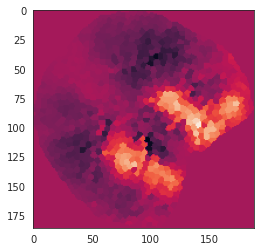

In [399]:
sns.set_style('white')
plt.imshow(x[..., 4500])

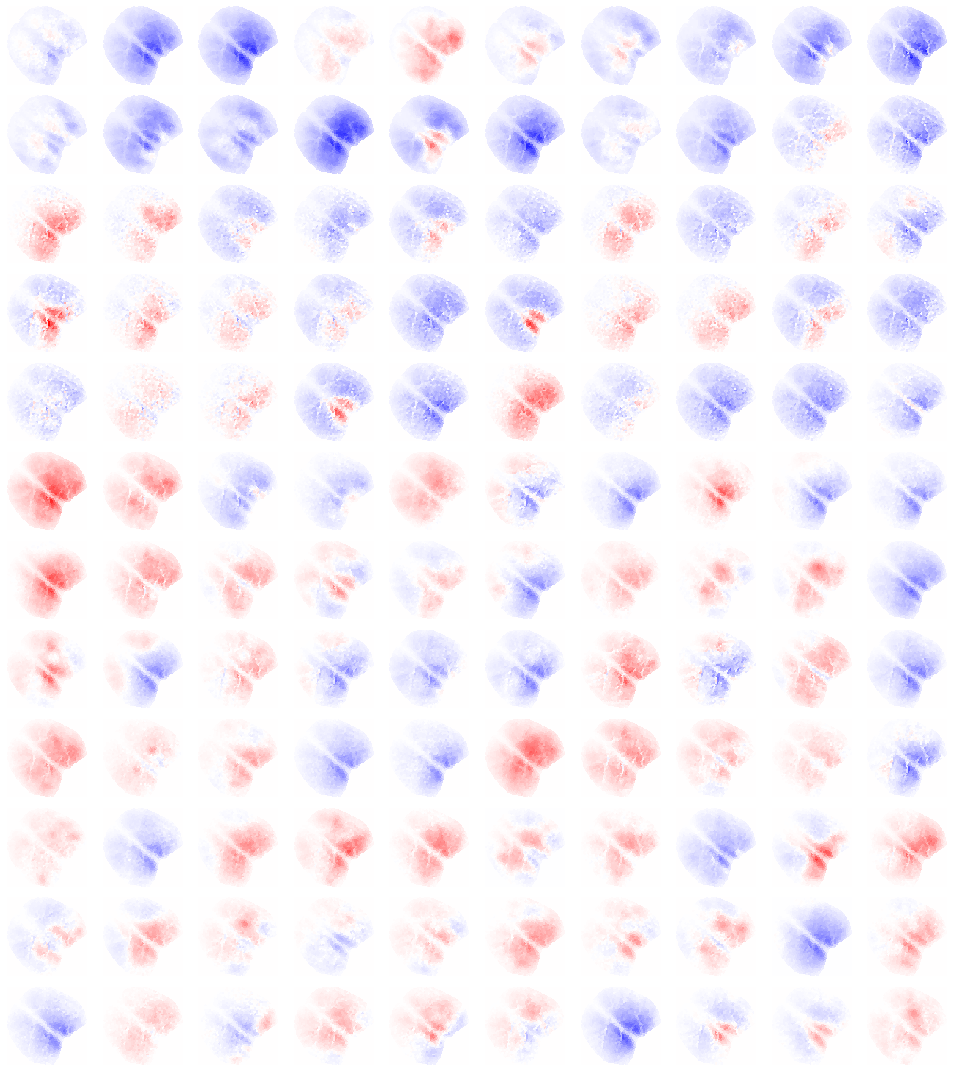

In [400]:
# t = 1800
t = 3500
res = 10

_slice = x[..., t: t + res * 120]
vminmax = np.max(np.abs(_slice))

sns.set_style('white')
nrows, ncols = 12, 10
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 15))

for idx in range(_slice.shape[-1] // res):
    i, j = idx//ncols, idx%ncols
    axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
    axes[i, j].axis('off')
    
fig.tight_layout()
plt.show()

In [ ]:
aaa

<AxesSubplot:xlabel='mu', ylabel='sd'>

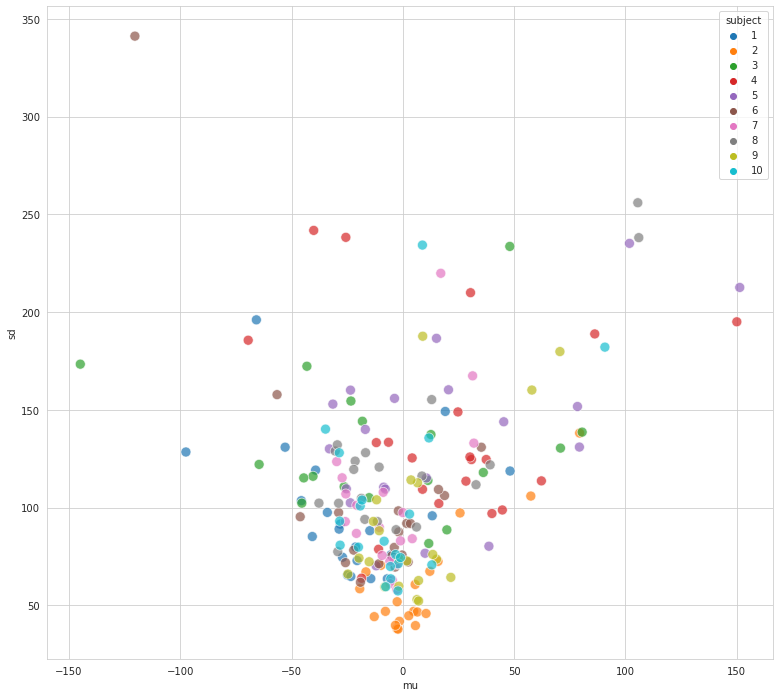

In [141]:
selected_df = df.loc[(df.num_regions == 256) & (df.mu < 1000)]

palette = {i+1: 'C{:d}'.format(i) for i in range(config.num_subjects)}

sns.set_style('whitegrid')
plt.figure(figsize=(13, 12))
sns.scatterplot(
    data=selected_df,
    x='mu',
    y='sd',
    hue='subject',
    palette=palette,
    s=100,
    alpha=0.7,
)

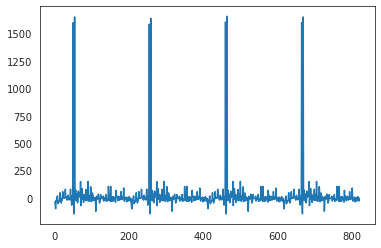

In [131]:
plt.plot(df.mu)

In [132]:
extreme_df = df.loc[df.mu > 1000]

In [133]:
extreme_df

num_regions  subject  session  run           mu           sd
49            32        3        2    2  1597.116955  2633.963079
53            32        3        2    6  1649.348618  2721.862042
254          128        3        2    2  1584.145019  2636.826383
258          128        3        2    6  1636.831984  2723.629068
459          256        3        2    2  1603.137533  2670.423103
463          256        3        2    6  1655.759445  2756.898508
664         1024        3        2    2  1596.874925  2667.052726
668         1024        3        2    6  1649.246133  2752.533379

In [54]:
df.mu.argsort()[:3], df.mu.argsort()[-3:]

(0    461
 1     51
 2    666
 Name: mu, dtype: int64,
 817    668
 818     53
 819    463
 Name: mu, dtype: int64)

In [52]:
df.iloc[461]

num_regions    256.000000
subject          3.000000
session          2.000000
run              4.000000
mu            -144.903823
sd             173.411227
Name: 461, dtype: float64

In [55]:
df.iloc[463]

num_regions     256.000000
subject           3.000000
session           2.000000
run               6.000000
mu             1655.759445
sd             2756.898508
Name: 463, dtype: float64

In [81]:
idx = df.mu.argsort().tolist()[-1]
df.iloc[idx]

num_regions     256.000000
subject           3.000000
session           2.000000
run               6.000000
mu             1655.759445
sd             2756.898508
Name: 463, dtype: float64

In [85]:
int(df.iloc[idx].subject), int(df.iloc[idx].session), int(df.iloc[idx].run)

(3, 2, 6)

In [66]:
load = load_organized_data(
    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
    config=config,
    subject=int(df.iloc[idx].subject),
    session=int(df.iloc[idx].session),
    run=int(df.iloc[idx].run),
)

In [67]:
x = np.zeros(load['atlas_kmeans'].shape + (list(load['ca'].values())[0].shape[-1],))

for key, data in load['ca'].items():
    
    num_nan = np.isnan(load['ca'][key]).mean().sum()
    if num_nan > 0:
        print(key, num_nan)
        continue
    
    x[load['atlas_kmeans'] == key] = load['ca'][key]

x.shape

(187, 193, 5500)

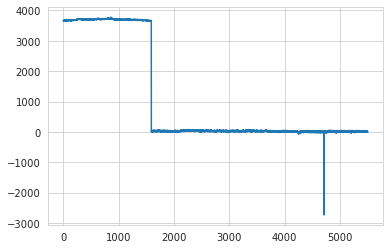

In [68]:
plt.plot(x.mean(0).mean(0))

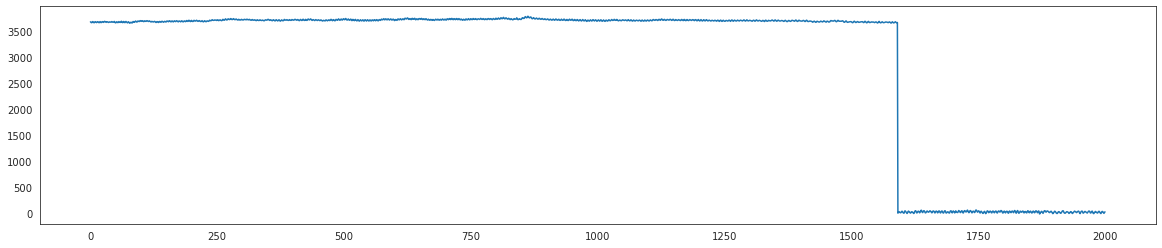

In [72]:
plt.figure(figsize=(20, 4))
plt.plot(x.mean(0).mean(0)[:2000])

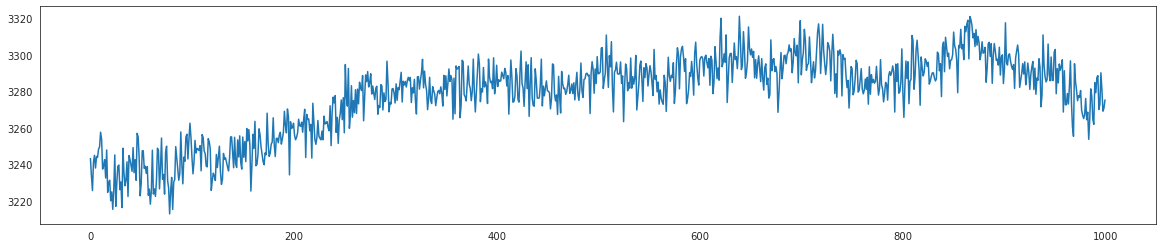

In [76]:
plt.figure(figsize=(20, 4))
plt.plot(x[46, 57][:1000])

In [86]:
df.iloc[idx].subject

3.0

In [490]:
load_raw = load_ca_with_extras(
    subject=7,
    session=2,
    run=2,
)

load_raw2 = load_ca_with_extras(
    subject=7,
    session=2,
    run=7,
)

Loading:
sub-SLC07_ses-2_run-2_task-led_ca.npy

-->  50 s  <-- excluded from the beginning of each run. Combined runs duration:
00 - 00:09:10  (dd - hh:mm:ss)

Loading:
sub-SLC07_ses-2_run-7_task-rest_ca.npy

-->  50 s  <-- excluded from the beginning of each run. Combined runs duration:
00 - 00:09:10  (dd - hh:mm:ss)



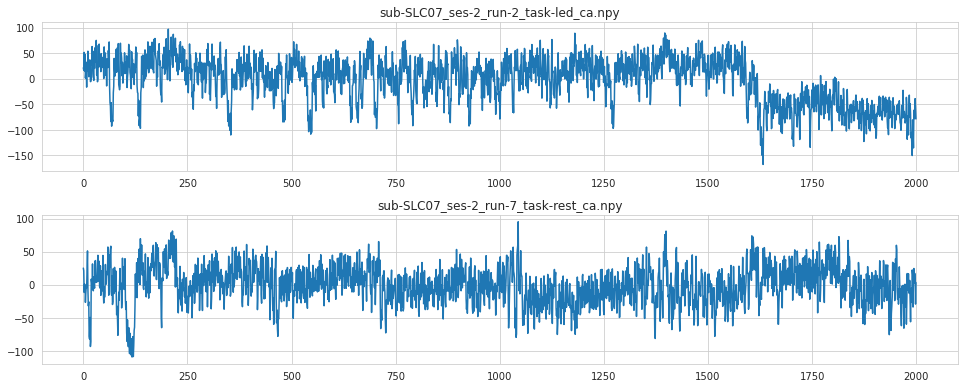

In [491]:
sns.set_style('whitegrid')
plt.figure(figsize=(13.5, 5.5))

plt.subplot(211)
plt.plot(load_raw['ca'].mean(0).mean(0)[:2000])
plt.title(load_raw['file_name'])

plt.subplot(212)
plt.plot(load_raw2['ca'].mean(0).mean(0)[:2000])
plt.title(load_raw2['file_name'])

plt.tight_layout()
# plt.savefig('bug_sub-SLC03_ses-2_run-[2,6].png')
plt.show()

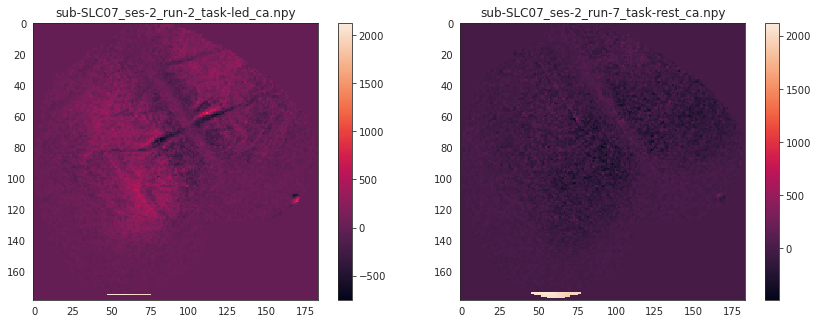

In [532]:
sns.set_style('white')
plt.figure(figsize=(12, 4.5))
plt.subplot(121)
plt.imshow(load_raw['ca'][..., 1200], interpolation='none')
plt.title(load_raw['file_name'])
plt.colorbar()

plt.subplot(122)
plt.imshow(load_raw2['ca'][..., 1200], interpolation='none')
plt.title(load_raw2['file_name'])
plt.colorbar()

plt.tight_layout()
plt.savefig('bug_sub-SLC07_ses-2_run-[2,7].png')
plt.show()

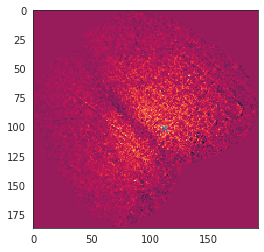

In [111]:
plt.imshow(load_raw['ca'][..., 4500], interpolation='none')
plt.plot(112, 101, marker='x')

In [513]:
x = load_raw['ca'].copy()

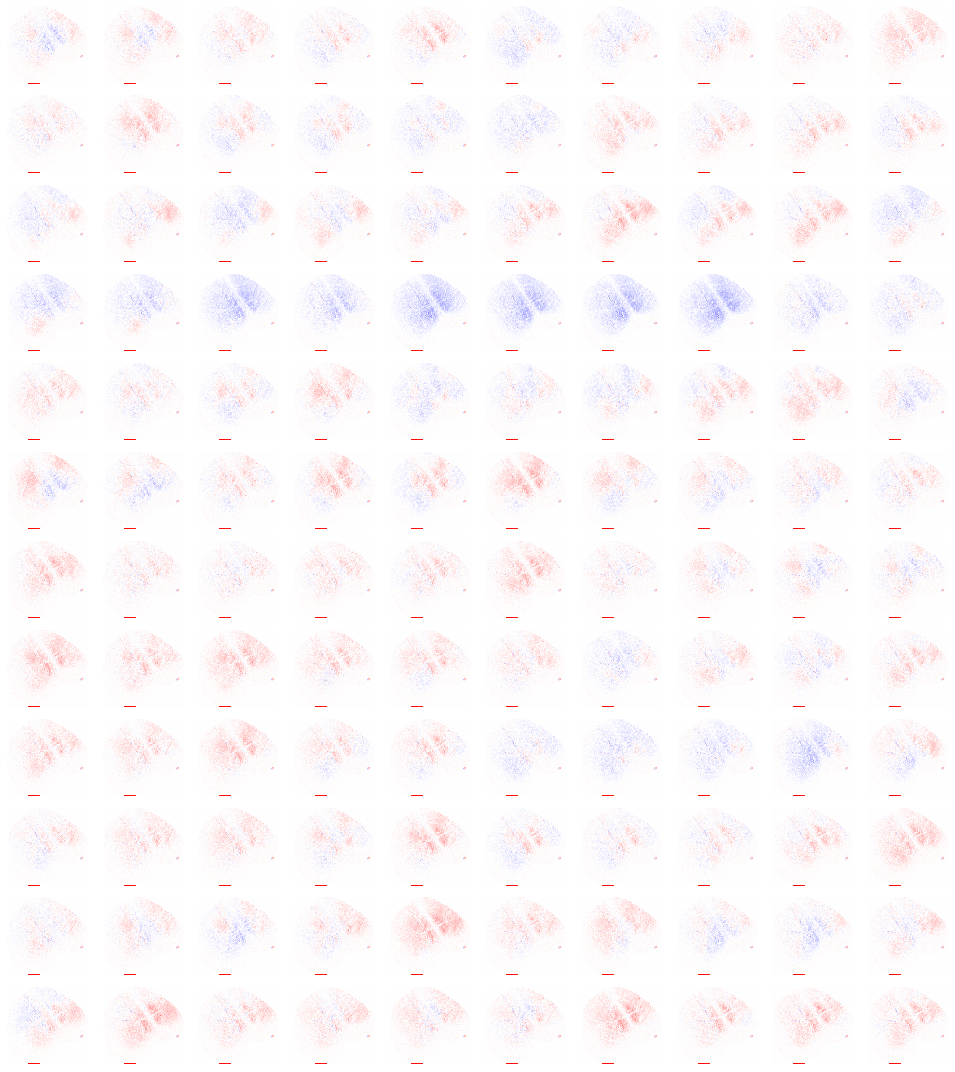

In [515]:
# t = 1800
t = 100
res = 1

_slice = x[..., t: t + res * 120]
vminmax = np.max(np.abs(_slice))

sns.set_style('white')
nrows, ncols = 12, 10
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 15))

for idx in range(_slice.shape[-1] // res):
    i, j = idx//ncols, idx%ncols
    axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
    axes[i, j].axis('off')
    
fig.tight_layout()
plt.show()

In [509]:
vminmax

432.9723603621773

## Community: Kmeans vs anatomical

### 128

In [430]:
num_regions = 512

data_all = {}
for run in [1, 3, 5, 7]:
    data_all[run] = load_organized_data(
        folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
        subject=6,
        session=1,
        run=run,
    )

In [431]:
df = pd.DataFrame()

for run, load in data_all.items():
    x_dict = data_all[run]['ca'].copy()
    x = np.concatenate([item.reshape(1, -1) for item in x_dict.values()])
    mean, std = x.mean(), x.std()
    x_dict_normalized = {k: (v - mean) / std for k, v in x_dict.items()}
    df = pd.concat([df, pd.DataFrame.from_dict(x_dict_normalized)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

1             2             3             4             5    \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.015576     -0.016330     -0.014932     -0.016951     -0.016333   
std        0.243902      0.257521      0.255347      0.225571      0.291708   
min       -0.878514     -0.983421     -0.896685     -0.841565     -1.071174   
25%       -0.176944     -0.186837     -0.183101     -0.164631     -0.211731   
50%       -0.018607     -0.016937     -0.018789     -0.020404     -0.019802   
75%        0.135784      0.150518      0.147910      0.121159      0.170019   
max        1.088701      1.157435      1.159823      1.146705      1.277094   

                6             7             8             9             10   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.016529     -0.007332     -0.016444     -0.009750     -0.015631   
std        0.269305      0.275015      0.202851      0.309472      0.304737   
min       -1.021744     -1.126139     -0.743395     -0.997837     -1.035331   
25%       -0.190817     -0.189469     -0.146977     -0.218243     -0.224480   
50%       -0.014536     -0.009886     -0.021926     -0.015111     -0.024063   
75%        0.159620      0.168614      0.107075      0.189148      0.183015   
max        1.293053      1.224017      0.971149      1.545293      1.318778   

       ...           503           504           505           506  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...     -0.034172     -0.018994     -0.022956     -0.026412   
std    ...      0.517897      0.403787      0.395511      0.460453   
min    ...     -1.906475     -1.385321     -1.440558     -1.797572   
25%    ...     -0.376370     -0.284475     -0.285311     -0.332559   
50%    ...     -0.032743     -0.024053     -0.023506     -0.023605   
75%    ...      0.297815      0.231525      0.230970      0.268846   
max    ...      3.510214      3.396821      2.060780      2.666833   

                507           508           509           510           511  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.017878     -0.017257     -0.024939     -0.016166     -0.008691   
std        0.416147      0.387208      0.412840      0.359771      0.315424   
min       -1.585460     -1.352208     -1.695714     -1.340215     -1.098001   
25%       -0.294114     -0.274950     -0.304429     -0.255703     -0.217848   
50%       -0.022649     -0.026292     -0.025078     -0.025470     -0.016091   
75%        0.242803      0.223288      0.238567      0.206524      0.185098   
max        2.801418      2.593310      2.583866      2.123589      1.690323   

                512  
count  22000.000000  
mean      -0.008810  
std        0.295800  
min       -1.041329  
25%       -0.207126  
50%       -0.019361  
75%        0.172955  
max        2.175212  

[8 rows x 512 columns]

In [435]:
thresholds = [0.70, 0.75, 0.77, 0.78, 0.79, 0.80, 0.82]
corrs = get_corrs(df, thresholds=thresholds)

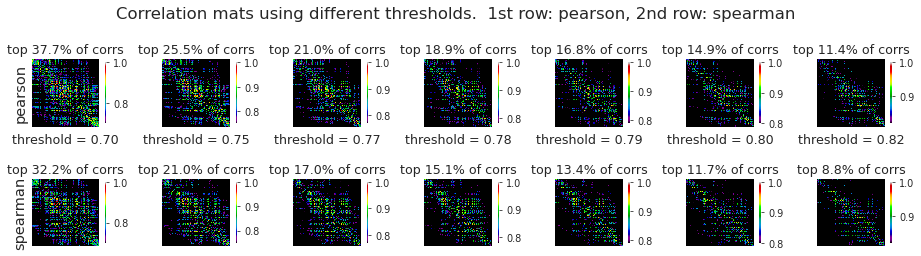

In [436]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

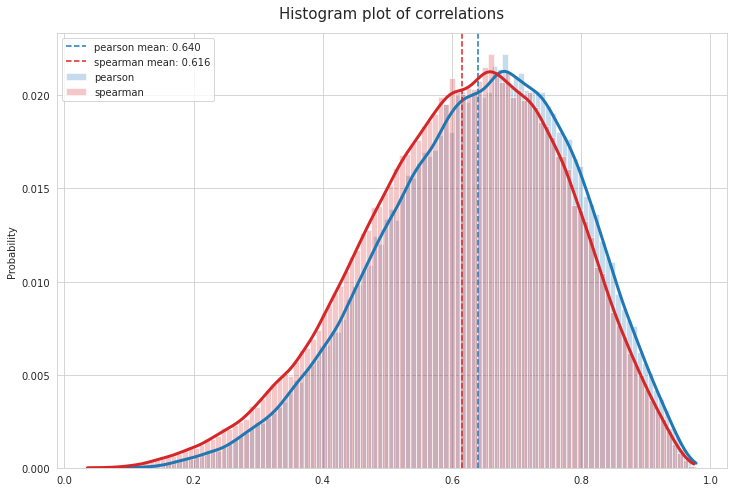

In [437]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [455]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [456]:
results_louvain = run_louvain(graphs[0.70], res=np.logspace(-0.3, 0.3, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

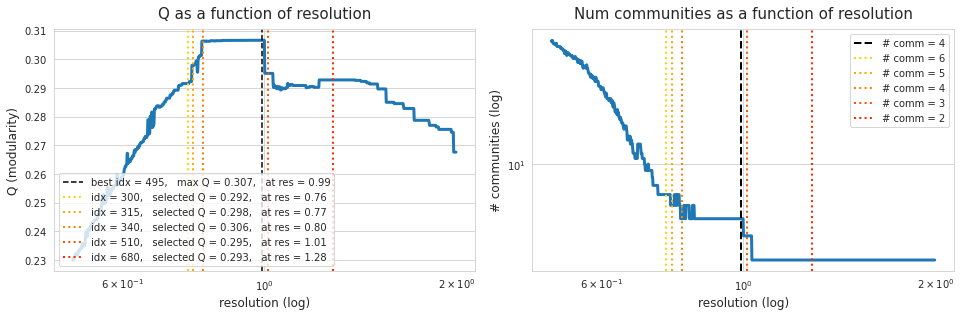

In [470]:
selected_idxs = [300, 315, 340, 510, 680]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

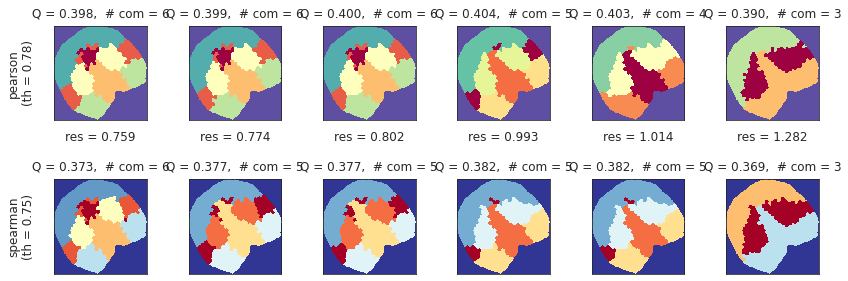

In [478]:
# selected_idxs = [450, 540, 585, 680] # [440, 520, 530, 590]

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.78,
    spearman_th=0.75,
    figsize=(12, 4),
    colorbar=False, )

In [452]:
fig.savefig('louvain_{:d}.pdf'.format(num_regions), dpi=100)

### Allen

In [413]:
data_all = {}
for run in [1, 3, 5, 7]:
    data_all[run] = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        subject=6,
        session=1,
        run=run,
    )

In [414]:
df = pd.DataFrame()

for run, load in data_all.items():
    x_dict = data_all[run]['ca'].copy()
    x = np.concatenate([item.reshape(1, -1) for item in x_dict.values()])
    mean, std = x.mean(), x.std()
    x_dict_normalized = {k: (v - mean) / std for k, v in x_dict.items()}
    df = pd.concat([df, pd.DataFrame.from_dict(x_dict_normalized)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

2             3             4             5             6    \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.014222     -0.015646     -0.013182     -0.002818      0.016089   
std        0.541672      0.401395      0.544768      1.050007      1.091835   
min       -2.090138     -1.664967     -1.823267     -3.528780     -3.492999   
25%       -0.368519     -0.270327     -0.389271     -0.727548     -0.717184   
50%       -0.011388     -0.016244     -0.028211     -0.025918     -0.016705   
75%        0.340526      0.232021      0.338943      0.685105      0.729793   
max        3.258669      2.840883      2.705093      5.458090      6.645909   

                7             8             9             10            11   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.013791     -0.005555      0.041341     -0.007254     -0.006985   
std        0.363962      0.830811      1.658102      0.924634      0.716810   
min       -1.345711     -2.793856     -5.078311     -3.193386     -2.273137   
25%       -0.260354     -0.566781     -1.089361     -0.643342     -0.504585   
50%       -0.020613     -0.022091     -0.025909     -0.028908     -0.025339   
75%        0.222482      0.546329      1.104790      0.604741      0.455403   
max        1.594632      4.100670      8.935480      4.862756      4.046291   

       ...           525           526           528           530  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...     -0.029206     -0.014502     -0.003475     -0.014626   
std    ...      0.433792      0.935283      0.342929      0.154776   
min    ...     -1.658327     -2.998129     -1.320056     -0.634472   
25%    ...     -0.317294     -0.655384     -0.212617     -0.118062   
50%    ...     -0.028354     -0.030394     -0.016986     -0.015098   
75%    ...      0.250553      0.598931      0.183595      0.081536   
max    ...      2.257118      5.007505      4.796357      0.974118   

                538           539           540           541           655  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       0.024293      0.055400      0.053549     -0.029575      0.021877   
std        1.451832      1.897442      1.431166      0.393712      0.730806   
min       -5.322611     -6.587831     -6.075199     -1.507418     -2.725311   
25%       -0.851856     -1.112244     -0.838438     -0.290850     -0.448369   
50%        0.083207      0.136200      0.068298     -0.025670      0.019102   
75%        0.965031      1.245081      0.868542      0.227096      0.452099   
max       10.581330     14.146948     17.118085      1.923165      9.821538   

                656  
count  22000.000000  
mean      -0.013121  
std        0.548553  
min       -2.046034  
25%       -0.363259  
50%       -0.022726  
75%        0.314880  
max        5.349386  

[8 rows x 61 columns]

In [417]:
thresholds = [0.75, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83]
corrs = get_corrs(df, thresholds=thresholds)

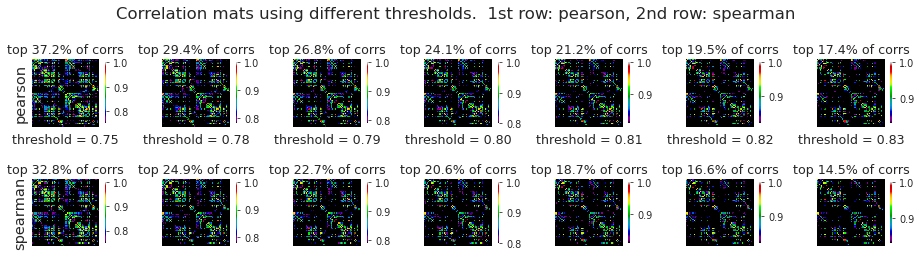

In [418]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

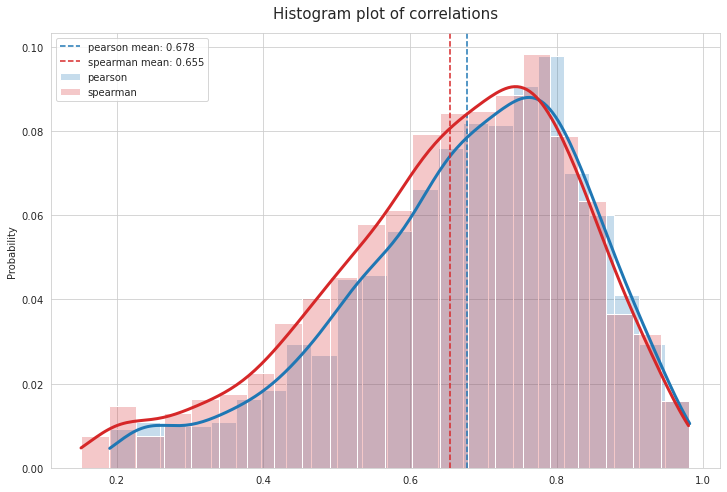

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Histogram plot of correlations'}, ylabel='Probability'>)

In [419]:
plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [420]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [421]:
results_louvain = run_louvain(graphs[0.82], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

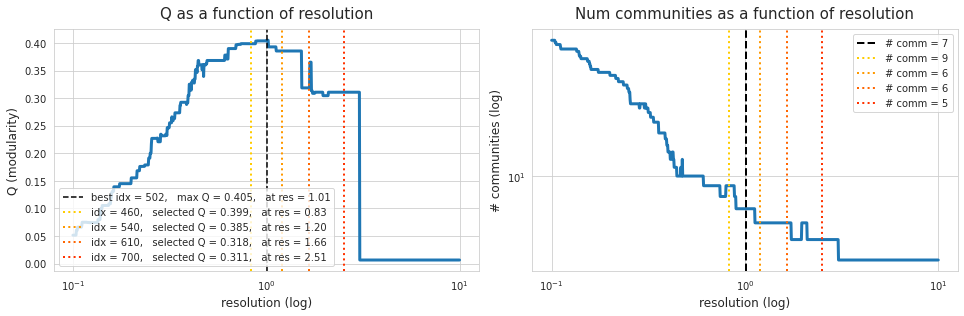

In [424]:
selected_idxs = [460, 540, 610, 700]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

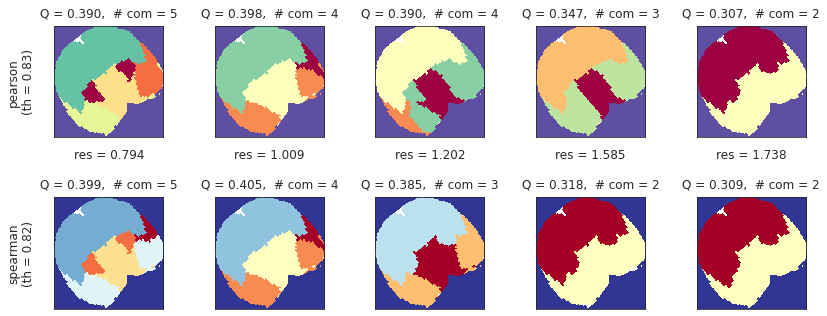

In [428]:
selected_idxs = [450, 540, 600, 620] # [440, 520, 530, 590]

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.83,
    spearman_th=0.82,
    figsize=(12, 4.5),
    colorbar=False, )

In [429]:
fig.savefig('louvain_allen.pdf', dpi=100)